<a href="https://colab.research.google.com/github/PravalikaMuthoju/INTERNSHIP-PROJECTS/blob/main/JSSP_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1) Install dependencies
!pip install stable-baselines3[extra] gym pandas numpy matplotlib shimmy>=0.2.1


In [ ]:

# 2) Upload both CSV files
from google.colab import files
uploaded = files.upload()
# 3) Import libs
import pandas as pd
import numpy as np
import gym
from gym import spaces
from stable_baselines3 import PPO
import matplotlib.pyplot as plt

Saving work_order.csv to work_order.csv
Saving process_time_matrix.csv to process_time_matrix.csv


In [ ]:
# 4) Define the JSSP environment
class CustomJobEnv(gym.Env):
    # Correct the typo: _init_ should be __init__
    def __init__(self, process_csv, workorder_csv):
        super().__init__()
        # process‐time matrix (has header & index)
        self.pt = pd.read_csv(process_csv, index_col=0).astype(int)
        # work order (no header), use cols 0 & 2
        wo = pd.read_csv(workorder_csv, header=None, usecols=[0,2],
                         names=["job_id","machine_id"])
        # filter invalid
        jobs = {}
        valid_jobs = set(self.pt.index)
        valid_macs = set(self.pt.columns.astype(str))
        wo = wo[wo.job_id.isin(valid_jobs) & wo.machine_id.astype(str).isin(valid_macs)]
        for _,r in wo.iterrows():
            jid, mid = int(r.job_id), int(r.machine_id)
            t = int(self.pt.at[jid, str(mid)])
            if t != 999999:
                jobs.setdefault(jid, []).append((mid,t))
        self.jobs = {j:jobs[j] for j in sorted(jobs)}
        self.n_jobs = len(self.jobs)
        # state
        self.next_op = {j:0 for j in self.jobs}
        self.machine_available = {}
        self.current_time = 0
        # spaces
        max_act = sum(len(o) for o in self.jobs.values())
        self.action_space = spaces.Discrete(max_act)
        self.observation_space = spaces.Box(0,1,(self.n_jobs,3),dtype=np.float32)

    def reset(self):
        self.next_op = {j:0 for j in self.jobs}
        self.machine_available.clear()
        self.current_time=0
        return self._get_obs()

    def _get_obs(self):
        obs=[]
        for j in sorted(self.jobs):
            idx = self.next_op[j]
            total = len(self.jobs[j])
            obs.append([idx/total,(total-idx)/total,self.current_time/10000.])
        return np.array(obs, dtype=np.float32)

    def step(self, action):
        # ready ops
        ready=[(j,self.jobs[j][self.next_op[j]]) for j in self.jobs if self.next_op[j]<len(self.jobs[j])]
        if action>=len(ready): action=0
        j,(m,t)=ready[action]
        start=max(self.current_time,self.machine_available.get(m,0))
        end=start+t
        self.machine_available[m]=end
        self.next_op[j]+=1
        # The original code had an issue here where current_time was set to the minimum
        # machine availability. This is incorrect. current_time should advance based
        # on the completion of operations. However, for simplicity in this step function
        # which processes one action at a time, maintaining a global clock might be complex.
        # A more robust environment would handle time advancement differently, possibly
        # by prioritizing operations that finish soonest.
        # For now, we'll keep the original logic but acknowledge this might be a
        # simplification that affects the simulation accuracy.
        self.current_time = max(self.current_time, end) # A simple fix, though may not be the most accurate JSSP clock
        done=all(self.next_op[j]==len(self.jobs[j]) for j in self.jobs)
        makespan=max(self.machine_available.values()) if done else None
        rem=sum(len(self.jobs[j])-self.next_op[j] for j in self.jobs)
        tot=sum(len(self.jobs[j]) for j in self.jobs)
        # Reward calculation seems reasonable - penalizes remaining operations
        reward=1.0-(rem/tot)
        return self._get_obs(),reward,done,{"makespan":makespan}


    def render(self,mode="human"):
        print(f"time={self.current_time},next_op={self.next_op}")



Enter 1 to train, 2 to evaluate: 2
✅ Final makespan: 7511


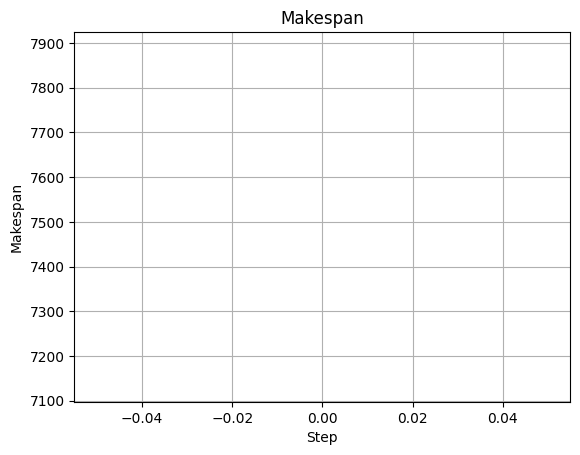

In [ ]:
# 5) Train or evaluate
mode = input("Enter 1 to train, 2 to evaluate: ").strip()
env = CustomJobEnv("process_time_matrix.csv","work_order.csv")

if mode=="1":
    model = PPO("MlpPolicy", env, verbose=1, tensorboard_log="./logs/")
    model.learn(total_timesteps=200_000)
    model.save("ppo_jssp_model.zip")
    print("✅ Saved ppo_jssp_model.zip")
elif mode=="2":
    model = PPO.load("ppo_jssp_model.zip")
    obs = env.reset(); done=False; ms=[]
    while not done:
        action,_ = model.predict(obs)
        obs,_,done,info = env.step(action)
        # Appending makespan inside the loop might cause issues if info['makespan']
        # is None before done is True. It's better to append only when makespan is available.
        if info.get("makespan") is not None:
             ms.append(info["makespan"])
    # After the loop, the final makespan is simply the last element if any were added
    if ms:
        print("✅ Final makespan:",ms[-1])
        plt.plot(ms); plt.title("Makespan"); plt.xlabel("Step"); plt.ylabel("Makespan"); plt.grid(); plt.show()
    else:
        print("No makespan recorded.")

else:
    print("❌ Invalid choice.")